# Starbucks Capstone Challenge Project

## Project Overview

In my capstone project, I aim to identify 2 main business questions:
1. What are the main drivers of an effective offer on the Starbucks app? 
2. Could the data provided, namely offer characteristics and user demographics, predict whether a user would take up an offer? 

This capstone project is using data provided by Udacity as part of the Data Scientist Nanodegree course. It contains simulated data that mimics customer behavior on the Starbucks rewards mobile app.

The provided background information on the mobile app is that once every few days, Starbucks sends out an offer to users of the mobile app. Some users might not receive any offer during certain weeks, and not all users receive the same offer.

### Problem Statement

As stated above, the problem statement I am aiming to answer are to (1) discover the main drivers of offer effectiveness, and (2) explore if we can predict whether a user would take up an offer.

The data provided consists of 3 datasets:
- Offer portfolio, which consists of the attributes of each offer
- Demographic data for each customer
- Transactional records of events occurring on the app

Using the data provided, I answer the above two questions using 3 classification supervised machine learning models, feeding in the data from three different offer types. I use the model to uncover the feature importances to identify the drivers of offer effectiveness, while exploring if the model itself could be used to predict if a user would take up an offer. Lastly, I also explore the characteristics of users who do or do not take up an offer.

### Imports & load in data

In [38]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn import svm
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

#from xgboost import XGBClassifier
%matplotlib inline

# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

### Data Exploration

#### a. Offer portfolio data

According to the information provided by Udacity, the schema is as follows:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

Moreover, some further information given about the offers is that there are 3 different offer types:
- BOGO - buy one get one free
- Discount - discount with purchase
- Informational - provides information about products

Thus, the schema is pretty straightforward, as it contains the attributes of 3 different offer types. While the duration was not explained I assumed from context that it is in terms of number of days.

In [39]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


The `channels` column consists of nested lists. Hence, I note that I will have to expand the column later during preprocessing to become categorical variables in my dataset. I also note that the scale of each are different, for example the `difficulty` is in terms of dollars while the `duration` is in terms of days. Hence, some feature scaling will need to be done.

In [40]:
#check for null values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

Good news is that there are no missing values in this dataset, hence we won't have to impute or make any decisions to remove them during the preprocessing stage.

In [41]:
#check no. of unique offers
portfolio.id.nunique()

10

In [42]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are 10 unique offer ids we will have to take note of, with 4 each of bogo and discount types, while 2 informational types.

#### b. Demographic data

Demographic data for customers is provided in the `profile` dataset. The schema and variables are as follows: 

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

It is also relatively straightforward, as it contains the demographic profile on the customer.

In [43]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


From the first 5 lines we can already see some null values in `gender` and `income`, while the `age` column contains some values that don't make sense (e.g. 118).

In [44]:
#check for null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

As suspected, the `gender` and `income` have null values. Some good news is that whichever values are null in `gender` are also null in `income`. 

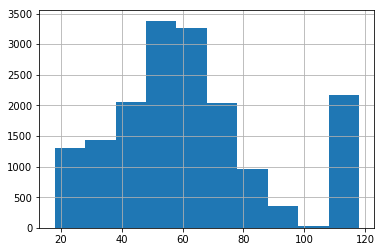

In [45]:
#check distribution of age column
profile.age.hist()

We can see above that the `age = 118` value does not make sense there as it is clearly out of the normal distribution.

In [46]:
#check count of age=118 value and corresponding gender and income columns
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


As we can see above, the `age=118` column corresponds with the null `gender` and `income` columns. Thus, we can actually drop them during preprocessing if they do not take too large a proportion of our data.

In [47]:
#check how many unique people are in dataset
profile['id'].nunique()

17000

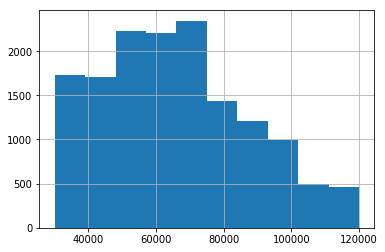

In [48]:
#check distributions of income
profile.income.hist()

#### c. Transactional records

The schema for the transactional data is as follows:

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [49]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [50]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

This data looks a bit more tricky, as it is ordered by time and has an event and value. In particular, the `value` column will have to be preprocessed depending on the event.

In [51]:
#check number of unique people represented
transcript['person'].nunique()

17000

It looks as though the number of people in transcript are the same as the number of people in the Demographics Data, so that is good news. But a lot of preprocessing will need to be done in order to extract meaningful insights out of this dataset.

In [52]:
#check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

There are no null values in this data.

In order to extract insights from the value column, I will have to expand the values into individual columns depending on the event.

In [53]:
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


It appears as though the `offer id` column ended up being duplicates so we have to clean it up further to ensure there is only one `offer id` column.

In [54]:
#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [55]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


Now the additional transcript columns can be used for further exploration.

### Defining approach for preprocessing data for the model

Before I proceeded to preprocess the data for the model, I first revisited my objective. Having done a preliminary exploration of the data, I had to reassess how I would clean and prepare the data for the models I intended to build.

In order to identify the main drivers of an effective offer, I have to first define what an 'effective' offer is within the Starbucks app. Thus, I did some further exploration on the datasets and how all three would interact.

First, I had to explore what kind of events are within each offer type.

In [56]:
#rename column
portfolio.rename(columns={'id':'offer_id'},inplace=True)

#join transcript with offer type
transcript=transcript.merge(portfolio,how='left',on='offer_id')

In [62]:
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

We know that there are 4 types of events: `offer completed`, `offer received`, `offer viewed` and `transaction`. But our data shows that we do not have any offer_id associated with `transactions`, because they are not recorded in the transcript event data. Thus, the first objective in data preprocessing is to define a methodology to assign offer_ids to specific transactions.

Moreover, we also know that BOGO and discount offers have an `offer completed` event when offers are completed. However, informational offers do not have this event associated with it. Thus, we also specify the approach to define an effective offer as follows:

For a BOGO and discount offer, an effective offer would be defined if the following events were recorded in the right sequence in time:

`offer received -> offer viewed -> transaction -> offer completed`

Meanwhile, for an informational offer, since there `offer completed` event associated with it, I will have to define transactions as a conversion to effective offer:

`offer received -> offer viewed -> transaction`

### Data Preprocessing

#### a. Assigning offer ids to transactions

After defining the approach above, we now have to explore methods to assign offer_ids to specific transactions. Among the 
considerations we were informed is that there could be some scenarios for an offer to be completed:

Effective offer:
`offer received -> offer viewed -> transaction -> offer completed`

Ineffective offer:
- `offer received -> transaction -> offer completed -> offer viewed`
- `transaction -> offer received -> offer completed -> offer viewed`
- `offer received -> transaction -> offer viewed -> offer completed`

In any of the scenarios above, an offer is considered 'ineffective' if an `offer completed` or `transaction` occurs before an `offer viewed`. 

There may be scenarios where an `offer completed` occurs after the offer is viewed, but a transaction was done prior to the offer being viewed. In this instance, the offer may have been completed, but it is also not a valid conversion.  

After defining these conditions, I can assign the offer id that 'influences' a transaction by ensuring that the transaction occurs after an `offer viewed` event. 

In [64]:
#define dropcolumns function as I will be doing this many times
def drop_cols(drop_cols,df,inplace=False):
    df=df.drop(columns=drop_cols,axis=1,inplace=inplace)
    return df

In [66]:
drop_cols(['value','reward_y'],transcript,inplace=True);

In [63]:
#sort events by person and time
transcript=transcript.sort_values(['person','time'])

After sorting the transcript dataset by person and time to ensure that each event for each person occurs in sequence, I can filter the dataset by events `offer viewed` and `transaction` to ensure that it only contains those events in order. 

Then, I can use pandas' `ffill()` method to fill every transaction with the offer_id of the viewed offer, only if it occurs before the transaction.

In [69]:
#filter dataset for transactions that occur after an offer is viewed, forward fill offer ids
offers_view_transacted=transcript[['time','offer_id','person','event']][(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].ffill()

Since the above temporary dataset is just a subset of the overall `transcript` dataset, I can create a new dataset with the filled in offer ids for transactions.

In [72]:
transactions_clean=transcript.merge(offers_view_transacted,how='left',on=['person','time','event'])

In [73]:
transactions_clean.head()

,event,person,time,amount,reward_x,offer_id_x,channels,difficulty,duration,offer_type,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed


In [74]:
#clean up dataset to unify multiple offer_id columns into one column
transactions_clean['offer_id']=np.where(transactions_clean['offer_id_x'].isnull(),transactions_clean['offer_id_y'],transactions_clean['offer_id_x'])

drop_cols(['offer_id_x','offer_id_y'],transactions_clean,inplace=True);

In [76]:
transactions_clean.head()

,event,person,time,amount,reward_x,channels,difficulty,duration,offer_type,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed


In [78]:
#re-merge portfolio dataset to get offer data for the transaction events
transactions_clean=transactions_clean.merge(portfolio,how='left',on='offer_id')
transactions_clean['duration']=np.where(transactions_clean['duration_x'].isnull(),transactions_clean['duration_y'],transactions_clean['duration_x'])
drop_cols(['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],transactions_clean,inplace=True);
transactions_clean.rename(columns={'channels_y':'channels','reward_x':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

In [81]:
transactions_clean.head()

,event,person,time,amount,reward,offer_id,channels,difficulty,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0


#### b. Flagging transactions and offers completed after offers viewed

The next important step for preparing our data for modeling and analysis is to identify a offer completed and transactions occurring after an offer is viewed.

Now that we have our dataset with the offer_ids populated for `transaction` events, we can  flag the converted transactions and completed offers. We have to first ensure that the offer id of the previous event is the same one. Since we have tagged the offer id for all viewed, transactions and completed offers, we can use the `offer_id` field to ensure that the previous offer consists of those events. 

This means that as long as the events `offer viewed`,`transaction`, and `offer completed` occur in the same sample space and are in the corrrect sequence of time, we can be assured that it is a transaction/completed offer occurring only after an offer is viewed.

In [82]:
#get sample space of events consisting of offer viewed, transactions and offer completed
offers_viewed_transactions_completed=transactions_clean[(transactions_clean['event']=='offer viewed') | (transactions_clean['event']=='transaction') | (transactions_clean['event']=='offer completed')].copy()

In [83]:
#add extra column to flag the previous offer id
offers_viewed_transactions_completed['offer_id_previous'] = offers_viewed_transactions_completed.groupby(['person','offer_id'])['offer_id'].shift()

In [84]:
#flag a completed transacton/offer completed as long as the previous offer id consists of events in the same sample space
offers_viewed_transactions_completed['valid_completed']=np.where(offers_viewed_transactions_completed['offer_id_previous']==offers_viewed_transactions_completed['offer_id'],1,0)

Since our dataset `offers_viewed_transactions_completed` consists of all other possible events, all we need to do is to append the all `offers received` events in the `transactions_clean` dataset to ensure we have our complete dataset again.

In [86]:
#get only offer received events
offers_received=transactions_clean[transactions_clean['event']=='offer received'].copy()

#ensure all columns are the same between datasets to be appended
offers_received['offer_id_previous']=np.nan
offers_received['valid_completed']=np.nan

#append datasets to complete dataset of transactions
transactions_clean2=offers_received.append(offers_viewed_transactions_completed)

#### c. Considering duration/validity of offers in converted transactions/offers

There is an additional rule to consider when considering an effective/converted transaction and offer. The `duration` of the offer can be considered to be the duration of the influence. Hence, we can make the assumption that an offer should only be considered effective if it is within the `duration` of the offer.

As we saw in our data dictionary, the `time` of an event in the `transcript` data is in terms of hours. In order to ensure it is on the same scale as the `duration` of the offer, we have to convert it into days.

In [92]:
#convert time into days
transactions_clean2['day_offer']=transactions_clean2['time']/24
#drop unnecessary column
drop_cols('time',transactions_clean2,inplace=True);

In [94]:
#sort transactions to ensure all events occurring by person and offer
transactions_clean2=transactions_clean2.sort_values(['person','day_offer','event','offer_id'])

We can get the difference between two events using the `diff` function in pandas. However, the key thing to note for 

### Implementation

#### a. Model Implementation

#### b. Refinement

### Conclusion